## Table of Content:

* [Sprint Velocity](#velocity)
* [Feature_Percent](#feature_percent)
* [Burnup](#mvp_burnup)


In [1]:
# >>> EDIT ITEMS IN THIS CELL

# Last complete sprint
last_sprint = 3

# Export the query from VSTS and save to the folder containing this notebook 
filename = "sample_data/team_sample_data_mac.csv"

# Define the sprint path up to sprint number
iteration_path = 'projectName\team1\Sprint '

# Change size of Feature Percent and Burnup graphs (width, height)
w = 10
h = 6

In [2]:
# Replace back slash with forward slash for iteration_path
split_t = iteration_path.split('\t')
temp_t = "/t".join([split for split in split_t])
split_n = temp_t.split('\n')
temp_n = "/n".join([split for split in split_n])
iteration_path = temp_n.replace('\\','/')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
# --- Import data and attach feature names to stories
df = pd.read_csv(filename, header = 0)
df = df.replace(np.nan, '', regex=True)

# Assign Feature label to User Story (diff for Mac)
df['Feature'] = ""
feature=df['Title'][0]
for i in range(0,len(df)):
    if df['Work Item Type'][i]!="Feature":
        df['Feature'][i]= feature;
        
    else:
        feature = df['Title'][i]
        df['Feature'][i] = feature


df['Iteration Path'] = df['Iteration Path'].replace({'Iteration':'Sprint'}, regex=True)
df['Iteration Path'] = df['Iteration Path'].replace(r'\\','/',regex=True)

it_paths = df['Iteration Path'].unique()

In [5]:
# --- Calculate Velocity

sprint_paths = [] #list
for value in it_paths:
    if 'Sprint' in value:
        sprint_paths.append(value)
    else:
        continue
        
total_sprints = len(sprint_paths)

df['Story Points'] = df[['Story Points']].convert_objects(convert_numeric=True).fillna(0)

# Find total number of stories and number of complete stories per sprint
total_points_per_sprint = []
closed_points_per_sprint = []
sprints = []
for i in range(1,(total_sprints+1)):
    sprint_name = iteration_path + str(i)
    sprints.append('Sprint '+str(i))
    
    num_closed_points = int(df[(df['Iteration Path']== sprint_name)&(df['State']=='Closed')].sum()["Story Points"])
    closed_points_per_sprint.append(num_closed_points)
    
    num_tot_points = int(df[(df['Iteration Path']== sprint_name)].sum()["Story Points"])
    total_points_per_sprint.append(num_tot_points)
    
sprintdf = {'Sprints':sprints, '# Story Points': total_points_per_sprint, '# Closed': closed_points_per_sprint}
sprintdf = pd.DataFrame (data = sprintdf)
sprintdf.loc[-1] = ['Sprint 0', 0,0]
sprintdf = sprintdf.sort_index()
sprintdf = sprintdf.reset_index(drop=True)
sprintdf['Points Cumsum'] = sprintdf['# Story Points'].cumsum()
sprintdf['Closed Cumsum'] = sprintdf['# Closed'].cumsum()

# --- Calculate points per feature

features = df['Feature'].unique()

total_MVP_points_per_feat = []
closed_MVP_points_per_feat = []
percent_MVP_complete = []
feat_iteration_path = []

for i in range(0,len(features)):
    num_closed_points = int(df[(df['Feature']== features[i])&(df['State']=="Closed")&(df['Iteration Path'].str.contains(iteration_path))].sum()["Story Points"])
    closed_MVP_points_per_feat.append(num_closed_points)
    
    num_tot_points = int(df[(df['Feature']== features[i])&(df['Iteration Path'].str.contains(iteration_path))].sum()["Story Points"])
    total_MVP_points_per_feat.append(num_tot_points)
    
    if num_tot_points != 0:
        percent = int(round(num_closed_points/num_tot_points*100))
        percent_MVP_complete.append(percent)
    else:
        percent_MVP_complete.append(0)
        
    feat_iteration_path.append(df[(df['Feature']==features[i])&(df['Work Item Type']=='Feature')].iloc[0]['Iteration Path'])
        
# combine into df    
featdf_all = {'Feature':features, '# Story Points': total_MVP_points_per_feat, '# Points Closed': closed_MVP_points_per_feat, '% MVP Complete': percent_MVP_complete, 'Iteration Path': feat_iteration_path}
featdf_all = pd.DataFrame (data = featdf_all)
featdf_all = featdf_all.dropna()


# Include only features with story points
featdf = featdf_all[(featdf_all['# Story Points']>0)]
featdf = featdf[::-1]

In [6]:
### Various dataframes
# df.head() 
# sprintdf.tail()
# MVP_featdf.head()

# Show stories in the feature: df[df['Feature']=='feature1']
df[df['Feature']=='feature1']

,ID,Work Item Type,Title,State,Story Points,Iteration Path,Feature
0,100,Feature,feature1,Closed,0.0,projectName/team1,feature1
1,111,User Story,story1,Closed,1.0,projectName/team1/Sprint 1,feature1
2,112,User Story,story2,Closed,1.0,projectName/team1/Sprint 1,feature1
3,113,User Story,story3,Closed,3.0,projectName/team1/Sprint 1,feature1


# Velocity  <a class="anchor" id="velocity"></a>

Average Velocity:  8.0 Story Points


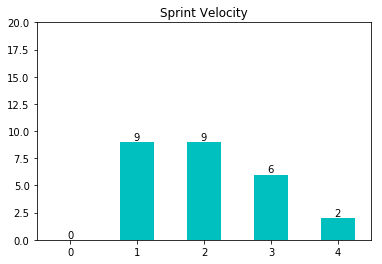

In [7]:
ax = sprintdf["# Closed"].plot.bar(title="Sprint Velocity",rot=0, color='c')
ax.set_ylim(0, 20)
for i, label in enumerate(list(sprintdf.index)):
    score = sprintdf.loc[label]['# Closed']
    ax.annotate(str(score), xy = (i, score), ha='center', va = 'bottom')
    
# Average sprint velocity for up to current sprint
print('Average Velocity: ', sprintdf.iloc[1:(last_sprint+1),2].sum()/(last_sprint), 'Story Points')

# Feature  Percent<a class="anchor" id="feature_percent"></a>

% Story Points Complete =  81.25
Total # Story Points =  32
# Remaining Story Points =  6


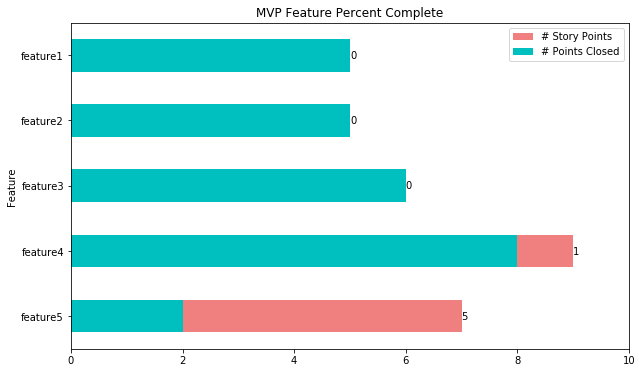

In [8]:
# Define x-axis max value
max_x = featdf['# Story Points'].max()
x_axis_max = (int(max_x/5)+1)*5

# Plot
ax1 = featdf.plot.barh(title="MVP Feature Percent Complete", x="Feature", y= "# Story Points",color='lightcoral', figsize = (w,h));
featdf.plot.barh(x="Feature", y= "# Points Closed", ax=ax1, color='c', width = 0.5);
ax1.set_yticklabels(featdf['Feature'], rotation=0);
ax1.set_xlim(0, x_axis_max);

for i, cards in enumerate(list(featdf['# Story Points'])):
    ax1.annotate(str(cards-featdf['# Points Closed'].iloc[i]), xy = (cards, i), va = "center")

# Number of MVP points
num_mvp = featdf['# Story Points'].sum()
mvp_left = featdf['# Story Points'].sum()-featdf['# Points Closed'].sum()
MVP_percent_complete = featdf['# Points Closed'].sum()/featdf['# Story Points'].sum()*100

print('% Story Points Complete = ', MVP_percent_complete.round(2))
print('Total # Story Points = ', num_mvp) 
print('# Remaining Story Points = ', mvp_left)

# Burnup <a class="anchor" id="mvp_burnup"></a>

Projected velocity =  8.1 Story Points
Estimated Completion: Sprint 3.95


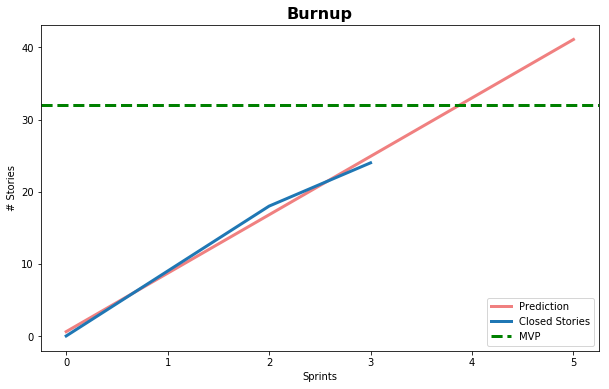

In [9]:
# complete_sprints
completeSprintdf = sprintdf[:last_sprint+1]

# Find linear fit
model = LinearRegression()
X = np.array(range(len(completeSprintdf['Points Cumsum']))).reshape(-1, 1)
model.fit(X, np.array(completeSprintdf['Points Cumsum']))

# Plot
# Projected average cards per sprint
print('Projected velocity = ', model.coef_[0].round(2),'Story Points')

# Estimated sprints to finish MVP
est_completion = num_mvp/model.coef_[0]
print('Estimated Completion: Sprint', est_completion.round(2))

fig = plt.figure(figsize = (w,h))
ax = fig.add_subplot(1, 1, 1)

plt.title("Burnup", fontsize=16, fontweight='bold')
plt.xlabel("Sprints")
plt.ylabel("# Stories")
ax.set_xticks(np.arange(0, int(est_completion) +3, 1))

X = np.array(range(int(est_completion) +3)).reshape(-1, 1)
plt.plot(X, model.predict(X), color='lightcoral', label='Prediction', linewidth = 3.0)
plt.plot(completeSprintdf['Closed Cumsum'], label = 'Closed Stories', linewidth = 3.0)
plt.axhline(y=num_mvp, color='g', linestyle='--', label='MVP', linewidth = 3.0)
plt.legend(loc='lower right')

plt.show()